This is a GUI demo built with [gradio](https://gradio.app/), **more powerful** than our [HuggingFace Demo 🤗](https://huggingface.co/spaces/xinyu1205/Recognize_Anything-Tag2Text), as this demo outputs not only tags and/or captions, but also **boxes** and **masks** from [Grounded-SAM](https://github.com/IDEA-Research/Grounded-Segment-Anything).

In [1]:
# set up our code
%pip install -r requirements.txt
%pip install -e .

# install gradio
%pip install --upgrade gradio

# set up Grounded-SAM
# you will need to clone Grounded-SAM repo
!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything.git
%cd ./Grounded-Segment-Anything
%pip install -r ./requirements.txt
%pip install ./segment_anything
%pip install ./GroundingDINO
%cd ..
%pip install opencv-python pycocotools matplotlib onnxruntime onnx ipykernel

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-xky8y15g
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-xky8y15g
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Obtaining file:///home/notebook/data/personal/recognize-anything
  Preparing metadata (setup.py) ... done
  Attempting uninstall: recognize-anything
    Found existing installation: recognize-anything 0.0.1
    Uninstalling recognize-anything-0.0.1:
      Successfully uninstalled recognize-anything-0.0.1
  Running setup.py develop for recognize-anything
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Cloning into 'Grounded-Segment-Anything'...
remote: Enumerating objects: 1547, done.
remote: Counting objects: 100

In [2]:
# arguments.
#
# before you go, please download following 4 checkpoints:
# download RAM and Tag2Text checkpoints to ./pretrained/ from https://github.com/majinyu666/recognize-anything/tree/main#toolbox-checkpoints
# download GroundingDINO and SAM checkpoints to ./Grounded-Segment-Anything/ from step 1 of https://github.com/IDEA-Research/Grounded-Segment-Anything#running_man-grounded-sam-detect-and-segment-everything-with-text-prompt
config_file = "./Grounded-Segment-Anything/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
ram_checkpoint = "./pretrained/ram_swin_large_14m.pth"
tag2text_checkpoint = "./pretrained/tag2text_swin_14m.pth"
grounded_checkpoint = "./Grounded-Segment-Anything/groundingdino_swint_ogc.pth"
sam_checkpoint = "./Grounded-Segment-Anything/sam_vit_h_4b8939.pth"
box_threshold = 0.25
text_threshold = 0.2
iou_threshold = 0.5
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# model loading, inference and visualization functions

import os
import random

import cv2
import groundingdino.datasets.transforms as T
import numpy as np
import torch
import torchvision
import torchvision.transforms as TS
from groundingdino.models import build_model
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from PIL import Image, ImageDraw, ImageFont
from ram import inference_ram
from ram import inference_tag2text
from ram.models import ram
from ram.models import tag2text
from segment_anything import SamPredictor, build_sam


def load_model(model_config_path, model_checkpoint_path, device):
    args = SLConfig.fromfile(model_config_path)
    args.device = device
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(
        clean_state_dict(checkpoint["model"]), strict=False)
    print(load_res)
    _ = model.eval()
    return model


def get_grounding_output(model, image, caption, box_threshold, text_threshold, device="cpu"):
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
    model = model.to(device)
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image[None], captions=[caption])
    logits = outputs["pred_logits"].cpu().sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"].cpu()[0]  # (nq, 4)
    logits.shape[0]

    # filter output
    logits_filt = logits.clone()
    boxes_filt = boxes.clone()
    filt_mask = logits_filt.max(dim=1)[0] > box_threshold
    logits_filt = logits_filt[filt_mask]  # num_filt, 256
    boxes_filt = boxes_filt[filt_mask]  # num_filt, 4
    logits_filt.shape[0]

    # get phrase
    tokenlizer = model.tokenizer
    tokenized = tokenlizer(caption)
    # build pred
    pred_phrases = []
    scores = []
    for logit, box in zip(logits_filt, boxes_filt):
        pred_phrase = get_phrases_from_posmap(
            logit > text_threshold, tokenized, tokenlizer)
        pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
        scores.append(logit.max().item())

    return boxes_filt, torch.Tensor(scores), pred_phrases


def draw_mask(mask, draw, random_color=False):
    if random_color:
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255), 153)
    else:
        color = (30, 144, 255, 153)

    nonzero_coords = np.transpose(np.nonzero(mask))

    for coord in nonzero_coords:
        draw.point(coord[::-1], fill=color)


def draw_box(box, draw, label):
    # random color
    color = tuple(np.random.randint(0, 255, size=3).tolist())
    line_width = int(max(4, min(20, 0.006*max(draw.im.size))))
    draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline=color,  width=line_width)

    if label:
        font_path = os.path.join(
            cv2.__path__[0], 'qt', 'fonts', 'DejaVuSans.ttf')
        font_size = int(max(12, min(60, 0.02*max(draw.im.size))))
        font = ImageFont.truetype(font_path, size=font_size)
        if hasattr(font, "getbbox"):
            bbox = draw.textbbox((box[0], box[1]), str(label), font)
        else:
            w, h = draw.textsize(str(label), font)
            bbox = (box[0], box[1], w + box[0], box[1] + h)
        draw.rectangle(bbox, fill=color)
        draw.text((box[0], box[1]), str(label), fill="white", font=font)

        draw.text((box[0], box[1]), label, font=font)


@torch.no_grad()
def inference(
    raw_image, specified_tags, do_det_seg,
    tagging_model_type, tagging_model, grounding_dino_model, sam_model
):
    print(f"Start processing, image size {raw_image.size}")
    raw_image = raw_image.convert("RGB")

    # run tagging model
    normalize = TS.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = TS.Compose([
        TS.Resize((384, 384)),
        TS.ToTensor(),
        normalize
    ])

    image = raw_image.resize((384, 384))
    image = transform(image).unsqueeze(0).to(device)

    # Currently ", " is better for detecting single tags
    # while ". " is a little worse in some case
    if tagging_model_type == "RAM":
        res = inference_ram(image, tagging_model)
        tags = res[0].strip(' ').replace('  ', ' ').replace(' |', ',')
        tags_chinese = res[1].strip(' ').replace('  ', ' ').replace(' |', ',')
        print("Tags: ", tags)
        print("图像标签: ", tags_chinese)
    else:
        res = inference_tag2text(image, tagging_model, specified_tags)
        tags = res[0].strip(' ').replace('  ', ' ').replace(' |', ',')
        caption = res[2]
        print(f"Tags: {tags}")
        print(f"Caption: {caption}")

    # return
    if not do_det_seg:
        if tagging_model_type == "RAM":
            return tags.replace(", ", " | "), tags_chinese.replace(", ", " | "), None
        else:
            return tags.replace(", ", " | "), caption, None

    # run groundingDINO
    transform = T.Compose([
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    image, _ = transform(raw_image, None)  # 3, h, w

    boxes_filt, scores, pred_phrases = get_grounding_output(
        grounding_dino_model, image, tags, box_threshold, text_threshold, device=device
    )
    print("GroundingDINO finished")

    # run SAM
    image = np.asarray(raw_image)
    sam_model.set_image(image)

    size = raw_image.size
    H, W = size[1], size[0]
    for i in range(boxes_filt.size(0)):
        boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
        boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
        boxes_filt[i][2:] += boxes_filt[i][:2]

    boxes_filt = boxes_filt.cpu()
    # use NMS to handle overlapped boxes
    print(f"Before NMS: {boxes_filt.shape[0]} boxes")
    nms_idx = torchvision.ops.nms(boxes_filt, scores, iou_threshold).numpy().tolist()
    boxes_filt = boxes_filt[nms_idx]
    pred_phrases = [pred_phrases[idx] for idx in nms_idx]
    print(f"After NMS: {boxes_filt.shape[0]} boxes")

    transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_filt, image.shape[:2]).to(device)

    masks, _, _ = sam_model.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes.to(device),
        multimask_output=False,
    )
    print("SAM finished")

    # draw output image
    mask_image = Image.new('RGBA', size, color=(0, 0, 0, 0))

    mask_draw = ImageDraw.Draw(mask_image)
    for mask in masks:
        draw_mask(mask[0].cpu().numpy(), mask_draw, random_color=True)

    image_draw = ImageDraw.Draw(raw_image)

    for box, label in zip(boxes_filt, pred_phrases):
        draw_box(box, image_draw, label)

    out_image = raw_image.convert('RGBA')
    out_image.alpha_composite(mask_image)

    # return
    if tagging_model_type == "RAM":
        return tags.replace(", ", " | "), tags_chinese.replace(", ", " | "), out_image
    else:
        return tags.replace(", ", " | "), caption, out_image

In [4]:
# load 4 models

# load RAM
ram_model = ram(pretrained=ram_checkpoint, image_size=384, vit='swin_l')
ram_model.eval()
ram_model = ram_model.to(device)

# load Tag2Text
delete_tag_index = []  # filter out attributes and action categories which are difficult to grounding
for i in range(3012, 3429):
    delete_tag_index.append(i)

tag2text_model = tag2text(pretrained=tag2text_checkpoint,
                                    image_size=384,
                                    vit='swin_b',
                                    delete_tag_index=delete_tag_index)
tag2text_model.threshold = 0.64  # we reduce the threshold to obtain more tags
tag2text_model.eval()
tag2text_model = tag2text_model.to(device)

# load groundingDINO
grounding_dino_model = load_model(config_file, grounded_checkpoint, device=device)

# load SAM
sam_model = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied
--------------
./pretrained/ram_swin_large_14m.pth
--------------
load checkpoint from ./pretrained/ram_swin_large_14m.pth
vit: swin_l
/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


-----
RAM:
Start processing, image size (3000, 2155)
Tags:  armchair, blanket, lamp, carpet, couch, dog, floor, furniture, gray, green, living room, picture frame, pillow, plant, room, sit, stool, wood floor
图像标签:  扶手椅, 毯子/覆盖层, 灯, 地毯, 沙发, 狗, 地板/地面, 家具, 灰色, 绿色, 客厅, 相框, 枕头, 植物, 房间, 坐/放置/坐落, 凳子, 木地板
GroundingDINO finished
Before NMS: 23 boxes
After NMS: 18 boxes
SAM finished


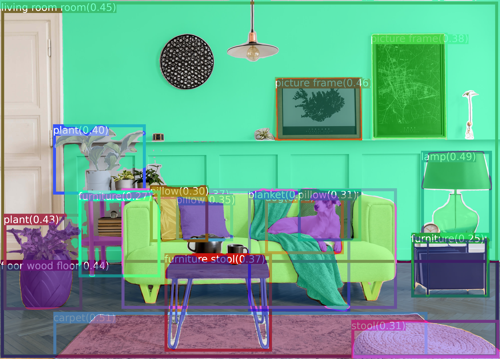

-----
Tag2Text:
Start processing, image size (3000, 2155)
Tags: room, table, couch, home, living room, sofa, blanket, dog, plant
Caption: a living room with a sofa, table, plants and a dog on the couch
GroundingDINO finished
Before NMS: 10 boxes
After NMS: 7 boxes
SAM finished


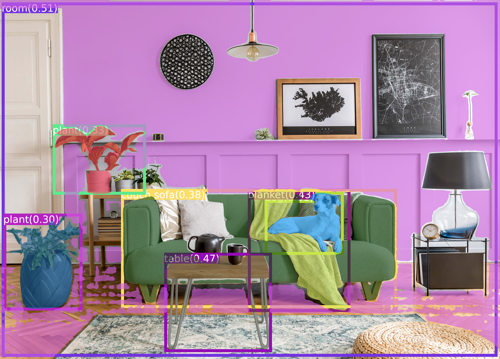

In [8]:
# let's try with an image

def inference_with_ram(img, do_det_seg):
    return inference(img, None, do_det_seg, "RAM", ram_model, grounding_dino_model, sam_model)

def inference_with_t2t(img, input_tags, do_det_seg):
    return inference(img, input_tags, do_det_seg, "Tag2Text", tag2text_model, grounding_dino_model, sam_model)

in_img = Image.open("images/demo/demo1.jpg")

print("-----\nRAM:")
ram_tags, ram_chinese_tags, ram_out_image = inference_with_ram(in_img, do_det_seg=True)
ram_out_image.thumbnail((500, 500))
display(ram_out_image)

print("-----\nTag2Text:")
t2t_tags, t2t_caption, t2t_out_image = inference_with_t2t(in_img, input_tags="", do_det_seg=True)
t2t_out_image.thumbnail((500, 500))
display(t2t_out_image)

In [9]:
# build interactive GUI

import gradio as gr

def build_gui():

    description = """
        <center><strong><font size='10'>Recognize Anything Model + Grounded-SAM</font></strong></center>
        <br>
        Welcome to the RAM/Tag2Text + Grounded-SAM demo! <br><br>
        <li>
            <b>Recognize Anything Model:</b> Upload your image to get the <b>English and Chinese tags</b>!
        </li>
        <li>
            <b>Tag2Text Model:</b> Upload your image to get the <b>tags and caption</b>!
            (Optional: Specify tags to get the corresponding caption.)
        </li>
        <li>
            <b>Grounded-SAM:</b> Tick the checkbox to get <b>boxes</b> and <b>masks</b> of tags!
        </li>
        <br>
        Great thanks to <a href='https://huggingface.co/majinyu' target='_blank'>Ma Jinyu</a>, the major contributor of this demo!
    """  # noqa

    article = """
        <p style='text-align: center'>
            RAM and Tag2Text are trained on open-source datasets, and we are persisting in refining and iterating upon it.<br/>
            Grounded-SAM is a combination of Grounding DINO and SAM aming to detect and segment anything with text inputs.<br/>
            <a href='https://recognize-anything.github.io/' target='_blank'>Recognize Anything: A Strong Image Tagging Model</a>
            |
            <a href='https://https://tag2text.github.io/' target='_blank'>Tag2Text: Guiding Language-Image Model via Image Tagging</a>
            |
            <a href='https://github.com/IDEA-Research/Grounded-Segment-Anything' target='_blank'>Grounded-Segment-Anything</a>
        </p>
    """  # noqa



    with gr.Blocks(title="Recognize Anything Model") as demo:
        ###############
        # components
        ###############
        gr.HTML(description)

        with gr.Tab(label="Recognize Anything Model"):
            with gr.Row():
                with gr.Column():
                    ram_in_img = gr.Image(type="pil")
                    ram_opt_det_seg = gr.Checkbox(label="Get Boxes and Masks with Grounded-SAM", value=True)
                    with gr.Row():
                        ram_btn_run = gr.Button(value="Run")
                        try:
                            ram_btn_clear = gr.ClearButton()
                        except AttributeError:  # old gradio does not have ClearButton, not big problem
                            ram_btn_clear = None
                with gr.Column():
                    ram_out_img = gr.Image(type="pil")
                    ram_out_tag = gr.Textbox(label="Tags")
                    ram_out_biaoqian = gr.Textbox(label="标签")
            gr.Examples(
                examples=[
                    ["images/demo/demo1.jpg", True],
                    ["images/demo/demo2.jpg", True],
                    ["images/demo/demo4.jpg", True],
                ],
                fn=inference_with_ram,
                inputs=[ram_in_img, ram_opt_det_seg],
                outputs=[ram_out_tag, ram_out_biaoqian, ram_out_img],
                cache_examples=True
            )

        with gr.Tab(label="Tag2Text Model"):
            with gr.Row():
                with gr.Column():
                    t2t_in_img = gr.Image(type="pil")
                    t2t_in_tag = gr.Textbox(label="User Specified Tags (Optional, separated by comma)")
                    t2t_opt_det_seg = gr.Checkbox(label="Get Boxes and Masks with Grounded-SAM", value=True)
                    with gr.Row():
                        t2t_btn_run = gr.Button(value="Run")
                        try:
                            t2t_btn_clear = gr.ClearButton()
                        except AttributeError:  # old gradio does not have ClearButton, not big problem
                            t2t_btn_clear = None
                with gr.Column():
                    t2t_out_img = gr.Image(type="pil")
                    t2t_out_tag = gr.Textbox(label="Tags")
                    t2t_out_cap = gr.Textbox(label="Caption")
            gr.Examples(
                examples=[
                    ["images/demo/demo4.jpg", "", True],
                    ["images/demo/demo4.jpg", "power line", False],
                    ["images/demo/demo4.jpg", "track, train", False],
                ],
                fn=inference_with_t2t,
                inputs=[t2t_in_img, t2t_in_tag, t2t_opt_det_seg],
                outputs=[t2t_out_tag, t2t_out_cap, t2t_out_img],
                cache_examples=True
            )

        gr.HTML(article)

        ###############
        # events
        ###############
        # run inference
        ram_btn_run.click(
            fn=inference_with_ram,
            inputs=[ram_in_img, ram_opt_det_seg],
            outputs=[ram_out_tag, ram_out_biaoqian, ram_out_img]
        )
        t2t_btn_run.click(
            fn=inference_with_t2t,
            inputs=[t2t_in_img, t2t_in_tag, t2t_opt_det_seg],
            outputs=[t2t_out_tag, t2t_out_cap, t2t_out_img]
        )

        # hide or show image output
        ram_opt_det_seg.change(fn=lambda b: gr.update(visible=b), inputs=[ram_opt_det_seg], outputs=[ram_out_img])
        t2t_opt_det_seg.change(fn=lambda b: gr.update(visible=b), inputs=[t2t_opt_det_seg], outputs=[t2t_out_img])

        # clear
        if ram_btn_clear is not None:
            ram_btn_clear.add([ram_in_img, ram_out_img, ram_out_tag, ram_out_biaoqian])
        if t2t_btn_clear is not None:
            t2t_btn_clear.add([t2t_in_img, t2t_in_tag, t2t_out_img, t2t_out_tag, t2t_out_cap])

    return demo

In [10]:
# launch GUI
build_gui().launch(
    server_name="127.0.0.1",  # localhost. use "0.0.0.0" to open to LAN
    share=True  # use True to acquire a temporary public address for sharing
)

Caching examples at: '/home/notebook/data/personal/recognize-anything/gradio_cached_examples/15'
Start processing, image size (3000, 2155)
Tags:  armchair, blanket, lamp, carpet, couch, dog, floor, furniture, gray, green, living room, picture frame, pillow, plant, room, sit, stool, wood floor
图像标签:  扶手椅, 毯子/覆盖层, 灯, 地毯, 沙发, 狗, 地板/地面, 家具, 灰色, 绿色, 客厅, 相框, 枕头, 植物, 房间, 坐/放置/坐落, 凳子, 木地板
GroundingDINO finished
Before NMS: 23 boxes
After NMS: 18 boxes
SAM finished
Start processing, image size (3000, 2000)
Tags:  blanket, building, christmas, christmas market, christmas tree, city, city square, crowded, person, market, market square, snow, stall, stroll, town, town square, walk
图像标签:  毯子/覆盖层, 建筑, 圣诞节, 圣诞市场, 圣诞树, 城市, 城市广场, 拥挤的, 人, 集市, 市场广场, 雪, 摊位/小隔间, 漫步, 小镇, 城镇广场, 走
GroundingDINO finished
Before NMS: 11 boxes
After NMS: 10 boxes
SAM finished
Start processing, image size (428, 640)
Tags:  bicycle, man, passenger train, railroad, red, ride, track, train, train track
图像标签:  自行车, 男人, 旅客列车, 铁道, 红色, 